<a href="https://colab.research.google.com/github/ahairshi/mlzoompcamp-cohort2022/blob/main/MLZoomcamp_hw4_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import LineString
from shapely.geometry import MultiLineString

%matplotlib inline

!python -m pip show scikit-learn

Name: scikit-learn
Version: 1.0.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, joblib, numpy, threadpoolctl
Required-by: yellowbrick, sklearn, sklearn-pandas, qudida, mlxtend, lightgbm, librosa, imbalanced-learn, fastai


## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 

In [2]:
!wget -P /content/mlzoomcamp/ https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-03 18:14:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘/content/mlzoomcamp/AER_credit_card_data.csv.1’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.03s   

2022-10-03 18:14:01 (2.33 MB/s) - ‘/content/mlzoomcamp/AER_credit_card_data.csv.1’ saved [73250/73250]



## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [3]:
df = pd.read_csv('/content/mlzoomcamp/AER_credit_card_data.csv')

print(len(df))
print((df.card == 'yes').sum())
print((df.card == 'no').sum())

card_values = {
    'yes': 1,
    'no': 0
}

df.card = df.card.map(card_values)


print((df.card == 1).sum())
print((df.card == 0).sum())

df.head(5).T

1319
1023
296
1023
296


,0,1,2,3,4
card,1,1,1,1,1
reports,0,0,0,0,0
age,37.66667,33.25,33.66667,30.5,32.16667
income,4.52,2.42,4.5,2.54,9.7867
share,0.03327,0.005217,0.004156,0.065214,0.067051
expenditure,124.9833,9.854167,15.0,137.8692,546.5033
owner,yes,no,yes,no,yes
selfemp,no,no,no,no,no
dependents,3,3,4,0,2
months,54,34,58,25,64


In [4]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[ mz_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) + " columns that have missing values.")
        return mz_table

In [5]:
missing_zero_values_table(df)

Your selected dataframe has 12 columns and 1319 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [6]:
df.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [7]:
numerical = df.iloc[:, (np.where((df.dtypes == np.int64) | (df.dtypes == np.float64)))[0]].columns.to_list()
numerical

['card',
 'reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [8]:
categorical = df.iloc[:, (np.where((df.dtypes == object)))[0]].columns.to_list()
categorical

['owner', 'selfemp']

In [9]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = \
        train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- <font color='blue'>`share`</font> 


In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

numerical = df_train.iloc[:, (np.where((df_train.dtypes == np.int64) | (df_train.dtypes == np.float64)))[0]].columns.to_list()
print(numerical)
result ={}
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    result[c] = round(auc,3)

sorted(result.items(), key=lambda x: x[1],reverse=True)    

['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']


[('expenditure', 0.991),
 ('share', 0.989),
 ('reports', 0.717),
 ('active', 0.604),
 ('income', 0.591),
 ('majorcards', 0.534),
 ('dependents', 0.533),
 ('months', 0.529),
 ('age', 0.524)]

## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [11]:


from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
columns=["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- <font color='blue'>0.995</font>


In [12]:
round(roc_auc_score(y_val, y_pred),3)

0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* <font color='blue'>0.3</font>
* 0.6
* 0.8

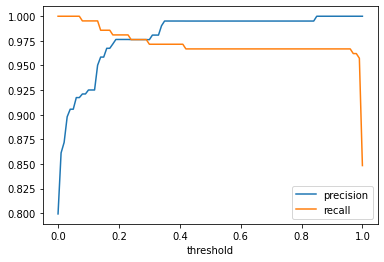

MULTILINESTRING ((0.24 0.976303317535545, 0.25 0.976303317535545), (0.25 0.976303317535545, 0.26 0.976303317535545), (0.26 0.976303317535545, 0.27 0.976303317535545), (0.27 0.976303317535545, 0.28 0.976303317535545), (0.28 0.976303317535545, 0.29 0.976303317535545))


6

In [13]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

first_line = LineString(np.column_stack((df_scores.threshold, df_scores.p)))
second_line = LineString(np.column_stack((df_scores.threshold, df_scores.r)))
intersection = first_line.intersection(second_line)

plt.legend()
plt.xlabel('threshold')
plt.show()

print(intersection)

((df_scores.p - df_scores.r) == 0).sum()


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- <font color='blue'>0.4</font>
- 0.6
- 0.7


In [14]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
max_f1 = np.max(f1_scores)
max_f1_thresh = thresholds[np.argmax(f1_scores)]
max_f1_thresh

0.41569074481307383

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- <font color='blue'>0.003</font>
- 0.014
- 0.09
- 0.24


In [15]:
from sklearn.model_selection import KFold
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- <font color='blue'>1</font>
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C


In [16]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C= 0.1, 0.995 +- 0.004
C=   1, 0.996 +- 0.003
C=  10, 0.996 +- 0.003
